In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wandb
import os, sys
import glob
import numpy as np
import torch
import pandas as pd
import random
import torch.nn as nn
import pickle
import torch.nn.functional as F

In [3]:
from mstcn_model import *
from utility.adaptive_data_loader import Breakfast, collate_fn_override
from utils import calculate_mof, dotdict

In [4]:
os.environ["WANDB_API_KEY"] = "992b3b1371ba79f48484cfca522b3786d7fa52c2"
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dipika_singhania (use `wandb login --relogin` to force relogin)


True

In [5]:
seed = 42

# Ensure deterministic behavior
def set_seed():
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
set_seed()

# Device configuration
os.environ['CUDA_VISIBLE_DEVICES']='5'
# os.environ['CUDA_LAUNCH_BLOCKING']='6'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
config = dotdict(
    epochs=500,
    num_class=48,
    batch_size=8,
    learning_rate=5e-4,
    weight_decay=0,
    dataset="Breakfast",
    architecture="unet-ensemble",
    features_file_name="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/",
    chunk_size=1,
    max_frames_per_video=1200,
    feature_size=2048,
    ground_truth_files_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/",
    label_id_csv="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv",
    gamma=0.1,
    step_size=500,
    split=3,
#     output_dir="/mnt/data/ar-datasets/dipika/breakfast/ms_tcn/data/breakfast/results/unsuper-finetune-split2-0.05-data-llr/",
    output_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-lenassum-mstcn-split3-slup15/",
    project_name="breakfast-split-3",
    train_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split{}.bundle",
    test_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split{}.bundle",
    all_files="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt",
    cutoff=8,
    data_per = 0.2,
    budget=40,
    semi_supervised_split="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/semi_supervised/train.split{}_amt{}.bundle")

config.train_split_file = config.train_split_file.format(config.split)
config.semi_supervised_split = config.semi_supervised_split.format(config.split, config.data_per)
config.test_split_file = config.test_split_file.format(config.split)

if not os.path.exists(config.output_dir):
    os.mkdir(config.output_dir)

print(config)

{'epochs': 500, 'num_class': 48, 'batch_size': 8, 'learning_rate': 0.0005, 'weight_decay': 0, 'dataset': 'Breakfast', 'architecture': 'unet-ensemble', 'features_file_name': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/', 'chunk_size': 1, 'max_frames_per_video': 1200, 'feature_size': 2048, 'ground_truth_files_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/', 'label_id_csv': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv', 'gamma': 0.1, 'step_size': 500, 'split': 3, 'output_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-lenassum-mstcn-split3-slup15/', 'project_name': 'breakfast-split-3', 'train_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split3.bundle', 'test_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split3.bundle', 'all_files': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt', 'cutoff': 8, 'data_per': 0.2, 'budget': 40, 'semi_supervised_

In [7]:
traindataset = Breakfast(config, fold='train', fold_file_name=config.train_split_file)
testdataset = Breakfast(config, fold='test', fold_file_name=config.test_split_file)

Number of videos logged in train fold is 1279
Number of videos not found in train fold is 0
Number of videos logged in test fold is 433
Number of videos not found in test fold is 0


In [8]:
def _init_fn(worker_id):
    np.random.seed(int(seed))
trainloader = torch.utils.data.DataLoader(dataset=traindataset,
                                          batch_size=config.batch_size, 
                                          shuffle=True,
                                          pin_memory=True, num_workers=4, 
                                          collate_fn=lambda x: collate_fn_override(x, config.max_frames_per_video),
                                          worker_init_fn=_init_fn)
testloader = torch.utils.data.DataLoader(dataset=testdataset,
                                          batch_size=config.batch_size, 
                                          shuffle=False,
                                          pin_memory=True, num_workers=4,
                                          collate_fn=lambda x: collate_fn_override(x, config.max_frames_per_video),
                                          worker_init_fn=_init_fn)

In [9]:
df=pd.read_csv(config.label_id_csv)
label_id_to_label_name = {}
label_name_to_label_id_dict = {}
for i, ele in df.iterrows():
    label_id_to_label_name[ele.label_id] = ele.label_name
    label_name_to_label_id_dict[ele.label_name] = ele.label_id

In [10]:
# item = iter(trainloader).next()
# print(item[0]) # -- data feature
# print(item[1]) # -- valid count
# item[2] # -- Actual labels
# print(item[5]) # video names
# video_id_boundary_frames

In [11]:
# selected_frames_dict = pickle.load(open("data/breakfast_len_assum_annotations.pkl", 'rb'))
# loaded_vidid_selected_frames
boundary_frames_dict = pickle.load(open("data/breakfast_boundary_annotations.pkl", "rb"))
# video_id_boundary_frames

In [12]:
loaded_mean_var_actions = pickle.load(open("data/breakfast_meanvar_actions.pkl", "rb"))
def get_possion_prob(cur_len, cur_class):
    mean_class, std_class = loaded_mean_var_actions[label_id_to_label_name[cur_class]]
    mean_class = mean_class
    prob = cur_len * torch.log(torch.tensor(mean_class, device=device) + 1e-5)
    prob = prob - mean_class
    factorials = torch.cumsum(torch.log(torch.arange(1, torch.max(cur_len)+1, 1).type(torch.float).to(device)), 
                              dim=0)[min(cur_len)-1:]
    prob = prob - factorials
    return prob

# get_possion_prob(torch.arange(10, 21), 20)

In [13]:
prob_video_each_segment_dict = {}

In [14]:
def prob_vals_per_segment(selected_frames, cur_vid_feat, labels):
    prob_each_segment = []
    
    log_probs = torch.log(cur_vid_feat + 1e-8)
    cumsum_feat = torch.cumsum(log_probs, dim=0)
    cur_boundary = 0
    for i, cur_ele in enumerate(selected_frames[:-1]):

        next_ele = selected_frames[i + 1]
        label_cur_ele = labels[i]
        label_next_ele = labels[i + 1]

        indices = torch.arange(cur_ele, next_ele).to(cumsum_feat.device)
        strt_index = cumsum_feat[cur_ele - 1, :][None, :] if cur_ele > 0 else 0
        end_index = cumsum_feat[next_ele - 1, :][None, :]
        left_sum = (cumsum_feat[indices, :] - strt_index)[:,label_cur_ele]
        right_sum = (end_index - cumsum_feat[indices, :])[:,label_next_ele]

        cur_boundary_len = indices - cur_boundary
        len_prob = get_possion_prob(cur_boundary_len, label_cur_ele)

        prob = torch.softmax((left_sum + right_sum + len_prob), dim=0)
#         prob = torch.softmax((left_sum + right_sum), dim=0)

        cur_boundary = round(np.sum(np.arange(cur_ele, next_ele, 1) * prob.detach().cpu().numpy()).item())
        prob_each_segment.append(prob)
    
    return prob_each_segment

In [15]:
def calculate_element_probb(data_feat, data_count, video_ids): #, loaded_vidid_selected_frames, boundaries_dict):
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        
        selected_frames_indices_and_labels = selected_frames_dict[cur_vidid + ".txt"]
        selected_frames_indices = [ele[0] for ele in selected_frames_indices_and_labels]
        selected_frames_labels = [label_name_to_label_id_dict[ele[1]] for ele in selected_frames_indices_and_labels]
        prob_video = prob_vals_per_segment(selected_frames_indices, cur_vid_feat, selected_frames_labels)
        prob_video_each_segment_dict[cur_vidid] = prob_video

In [16]:
def get_estimated_loss(data_feat, data_count, video_ids): #, loaded_vidid_selected_frames, boundaries_dict):
#     global prob_video_each_segment_dict, loaded_vidid_selected_frames
    loss_arr = []
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        
        selected_frames_indices_and_labels = selected_frames_dict[cur_vidid + ".txt"]
        selected_frames_indices = [ele[0] for ele in selected_frames_indices_and_labels]
        selected_frames_labels = [label_name_to_label_id_dict[ele[1]] for ele in selected_frames_indices_and_labels]

        prob_each_video = prob_video_each_segment_dict[cur_vidid]
        
        log_probs = torch.log(cur_vid_feat + 1e-8)
        cumsum_feat = torch.cumsum(log_probs, dim=0)
        
        
        current_vid_prob_arr = []
        # Start segment log probability
        start_ele_idx = selected_frames_indices[0]
        if start_ele_idx > 0:
            start_ele_label_idx = selected_frames_labels[0]
            first_segment_prob = (cumsum_feat[start_ele_idx - 1, :])[start_ele_label_idx]
            current_vid_prob_arr.append(first_segment_prob.unsqueeze(0))
        
        for i, cur_ele in enumerate(selected_frames_indices[:-1]):
            next_ele = selected_frames_indices[i + 1]
            label_cur_ele = selected_frames_labels[i]
            label_next_ele = selected_frames_labels[i + 1]

            indices = torch.arange(cur_ele, next_ele)
            strt_index = cumsum_feat[cur_ele - 1, :][None, :] if cur_ele > 0 else 0
            end_index = cumsum_feat[next_ele - 1, :][None, :]
            left_sum = (cumsum_feat[indices, :] - strt_index)[:,label_cur_ele]
            right_sum = (end_index - cumsum_feat[indices, :])[:,label_next_ele]
            current_vid_prob_arr.append((left_sum + right_sum)  * (prob_each_video[i]))
        
        # End segment log probability
        end_index = cur_vid_count.item() - 1
        last_ele_label_idx = selected_frames_labels[-1]
        last_segment_sum_prob = (cumsum_feat[end_index, :] - cumsum_feat[selected_frames_indices[-1] - 1, \
                                                                         :])[last_ele_label_idx]
        current_vid_prob_arr.append(last_segment_sum_prob.unsqueeze(0))
            
        loss_arr.append(torch.cat(current_vid_prob_arr))
    return -torch.mean(torch.cat(loss_arr)), loss_arr

In [17]:
train_split_file_list = set(open(config.train_split_file).read().split("\n")[0:-1])

def get_estimated_boundaries():
    estimated_boundary_dict = {}
    for video_id in train_split_file_list:
        ele = video_id.split(".txt")[0]
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        
        selected_frames_indices_and_labels = selected_frames_dict[video_id]
        selected_frames_indices = [ele[0] for ele in selected_frames_indices_and_labels]
        
        boundary_list = []
        for i, segment in enumerate(estimated_boundary_probs):
            estimated_boundary = np.sum(np.arange(selected_frames_indices[i], selected_frames_indices[i + 1], 1) \
                                        * segment.detach().cpu().numpy())
            estimated_boundary = round(estimated_boundary.item())
            
            if (estimated_boundary < selected_frames_indices[i]) or (estimated_boundary > selected_frames_indices[i + 1]):
                print("Estimated value wrong")
                import pdb
                pdb.set_trace()
            boundary_list.append(estimated_boundary)

        estimated_boundary_dict[ele] = boundary_list
    return estimated_boundary_dict

In [18]:
def get_boundary_err():
    err_list = []
    correct = 0.0
    total = 0.0
    estimated_boundar_dict = get_estimated_boundaries()
    for video_id in train_split_file_list:
        ele = video_id.split(".txt")[0]
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        estimated_boundary_list = estimated_boundar_dict[ele]
        
        estimated = np.array(estimated_boundary_list) #.detach().cpu().numpy()
        actual = np.array(boundary_frames_dict[video_id][:-1])
        if len(actual) != len(estimated):
            print(ele)
            continue
        
        mse_err = (actual - estimated)**2
        err_list.append(mse_err)
        
        estimated_labels = []
        actual_labels = []
        start_v1 = 0
        start_v2 = 0
        for i, v1 in enumerate(estimated):
            estimated_labels.extend([i] * (v1 - start_v1))
            start_v1 = v1
            v2 = actual[i]
            actual_labels.extend([i] * (v2 - start_v2))
            start_v2 = v2
            
        last_ele = boundary_frames_dict[video_id][-1]
        estimated_labels.extend([i+1] * (last_ele - start_v1))
        actual_labels.extend([i+1] * (last_ele - start_v2))
        
        correct += np.sum(np.array(actual_labels) == np.array(estimated_labels))
        total += len(actual_labels)
        
    print(f"Train Boundary avergage error = {np.sqrt(np.mean(np.concatenate(err_list))):.3f}")
    print(f"Train From boundary avergage accuracy = {correct * 100.0 / total:.3f}")

In [19]:
set_seed()
model = MultiStageModel(num_stages=4, num_layers=10, num_f_maps=64, dim=2048, num_classes=48).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# Requires loaded_vidid_selected_frames, boundaries_dict
ce_criterion = nn.CrossEntropyLoss(ignore_index=-100)
mse_criterion = nn.MSELoss(reduction='none')

In [20]:
# loaded_file=torch.load("/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/mstcn-lenpsuedo-full-supervised-split1/ms-tcn-best-model.wt")
# model.load_state_dict(loaded_file)

In [21]:
pseudo_labels_dir = "/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/length_segmentation_output/"
def get_single_random(output_p, video_ids):
    # Generate target for only timestamps. Do not generate pseudo labels at first 30 epochs.
    boundary_target_tensor = torch.ones((output_p.shape[0], output_p.shape[2]), dtype=torch.long, 
                                        device=output_p.device) * (-100)
    for iter_num, cur_vidid in enumerate(video_ids):
        pseudo_l = open(pseudo_labels_dir + cur_vidid + ".txt").read().split("\n")[0:-1]
        pseudo_l = [label_name_to_label_id_dict[ele] for ele in pseudo_l]
        abc = torch.tensor(pseudo_l).to(torch.long).to(boundary_target_tensor.device)
        frame_idx_tensor = torch.arange(0, len(pseudo_l), 1).to(device)
        boundary_target_tensor[iter_num, frame_idx_tensor] = abc

    return boundary_target_tensor

In [22]:
weakly_labels = pickle.load(open("data/breakfast_weaklysupervised_labels.pkl", "rb"))

In [31]:
prior_probs = pickle.load(open('data/breakfast_lengthmodel_multinomial_prior.pkl', 'rb'))

In [24]:
import copy
def change_selected_frames(model):
    global selected_frames_dict
    new_selected_frame_dict = {}
    with torch.no_grad():
        for train_idx, item in enumerate(trainloader):
            item_0 = item[0].to(device)
            item_1 = item[1].to(device)
            item_2 = item[2].to(device)
            src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
            src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)
            if train_idx % 10 == 0:
                print(f"Completed {train_idx} videos selected frames calculation")
            middle_pred, predictions = model(item_0, src_mask_mse)
            
            for idx, video_id in enumerate(item[4]):
                start = 0
                new_index_label_pair_list = []
                weakly_labels_video = [label_name_to_label_id_dict[wl] for wl in weakly_labels[video_id + ".txt"]]
                cur_video_predictions = predictions[-1][idx][:, :item_1[idx]]
                cur_preds_for_weakly_labels = torch.softmax(cur_video_predictions[weakly_labels_video], dim=0)
                prior_probs_cur_vid = prior_probs[video_id]
                weakly_labels_masked = []
                for i, prob_class in enumerate(cur_preds_for_weakly_labels):
                    prob_class_masked = prob_class * torch.tensor(prior_probs_cur_vid[i], 
                                                                  dtype=prob_class.dtype, device=prob_class.device)
                    weakly_labels_masked.append(prob_class_masked)
                    
                weakly_labels_masked = torch.stack(weakly_labels_masked)
                weakly_labels_masked = weakly_labels_masked / torch.sum(weakly_labels_masked, dim=0)

                for i in range(len(weakly_labels_video)):
                    cur_l = weakly_labels_video[i]
                    prob_class = weakly_labels_masked[i]
                    expected_value_of_class = torch.argmax(prob_class)
                    new_index_label_pair_list.append((int(expected_value_of_class.item()),
                                                      weakly_labels_video[i])) 
                
                back_list = copy.deepcopy(new_index_label_pair_list)
                error_list = []
                if new_index_label_pair_list[0][0] > new_index_label_pair_list[1][0]:
                    error_list.append(1)
                else:
                    error_list.append(0)
                for i in range(1, len(new_index_label_pair_list) - 1, 1):
                    err = 0
                    prev_ele = new_index_label_pair_list[i - 1]
                    cur_ele = new_index_label_pair_list[i]
                    next_ele = new_index_label_pair_list[i + 1]
                    if not (prev_ele[0] < cur_ele[0]):
                        err += 1
                    if not (cur_ele[0] < next_ele[0]):
                        err += 1
                    error_list.append(err)

                if new_index_label_pair_list[-1][0] < new_index_label_pair_list[-2][0]:
                    error_list.append(1)
                else:
                    error_list.append(0)
                    
                if error_list[0] == 1 and error_list[1] == 1:
                    new_index = new_index_label_pair_list[1][0] // 2
                    new_index_label_pair_list[0] = (new_index, new_index_label_pair_list[0][1])
                    error_list[0] = 0
                    error_list[1] = 0
                    
                if error_list[-1] == 1 and error_list[-2] == 1:
                    new_index = (new_index_label_pair_list[-2][0] + weakly_labels_masked.shape[1]) // 2
                    new_index_label_pair_list[-1] = (new_index, new_index_label_pair_list[-1][1])
                    error_list[-1] = 0
                    error_list[-2] = 0
                    
                start_flag = False
                start_index = -1
                end_index = -1
                for i in range(1, len(error_list) - 1):
                    if error_list[i] == 1 and error_list[i + 1] == 2:
                        start_flag = True
                        start_index = i
                        
                    if (start_flag is True) and (error_list[i] == 2 or error_list[i + 1] == 1):
                        start_flag = False
                        end_index = i + 1
                        
                        num_div = end_index - start_index - 1
                        increm = (new_index_label_pair_list[end_index][0] - \
                                  new_index_label_pair_list[start_index][0]) // num_div
                        value = list(range(new_index_label_pair_list[start_index][0], 
                                           new_index_label_pair_list[end_index][0], increm))
                        count = 0
                        for ch_i in range(start_index + 1, end_index):
                            old_ele = new_index_label_pair_list[ch_i]
                            new_ele = (value[count], old_ele[1])
                            new_index_label_pair_list[ch_i] = new_ele
                            count += 1
                    
                final_list = new_index_label_pair_list
                is_valid_list = True
                for i in range(1, len(final_list) - 1, 1):
                    cur_ele = final_list[i]
                    
                    if not (final_list[i - 1][0] < cur_ele[0] and cur_ele[0] < final_list[i + 1][0]):
                        is_valid_list  = False

                if is_valid_list == False:
                    print(f"Could not find expected solution for video {video_id}")
                    print(final_list)
                    print(back_list)
                    print(error_list)
                    new_selected_frame_dict[video_id + ".txt"] = selected_frames_dict[video_id + ".txt"]
                else:
                
                    label_name_final_list = []
                    for ele in final_list:
                        label_name_final_list.append((ele[0], label_id_to_label_name[ele[1]]))
                    new_selected_frame_dict[video_id + ".txt"] = label_name_final_list
                
        return new_selected_frame_dict

In [25]:
def get_new_selected_frame_acc(selected_frame_dict):
    correct = 0.0
    total = 0.0

    for video_id in selected_frame_dict.keys():
        ground_labels = open(config.ground_truth_files_dir + video_id).read().split("\n")[0:-1]
        ground_labels = np.array(ground_labels)

        selected_frames_index = [ele[0] for ele in selected_frame_dict[video_id]]
        selected_frames_labels = np.array([ele[1] for ele in selected_frame_dict[video_id]])

        ground_selected_labels = ground_labels[selected_frames_index]

        correct += np.sum(ground_selected_labels == selected_frames_labels)
        total += len(ground_selected_labels)

    print("Total correct pivots labels selected = ", correct * 100.0 / total)


In [26]:
# selected_frames_dict = change_selected_frames(model)
# get_new_selected_frame_acc(selected_frames_dict)

In [27]:
# Initialize Expection Boundaries
# print("Calculating Expectation")
# correct = 0.0
# total = 0.0
# model.eval()
# for i, item in enumerate(trainloader):
#     with torch.no_grad():
#         item_0 = item[0].to(device)
#         item_1 = item[1].to(device)
#         item_2 = item[2].to(device)
#         src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
#         src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

#         middle_pred, predictions = model(item_0, src_mask_mse)
#         prob = torch.softmax(predictions[-1], dim=1)
#         prob = prob.permute(0, 2, 1)
#         calculate_element_probb(prob, item_1, item[4])

#         if i % 10 == 0:
#             print(f"Completed iter {i}")

# get_boundary_err()

In [28]:
config.output_dir

'/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-lenassum-mstcn-split3-slup15/'

In [32]:
initialize_epoch = 25
expectation_cal_gap = 5
best_val_acc = 0

for epoch in range(25, 150):
    print("Starting Training")
    model.train()
    for i, item in enumerate(trainloader):
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)
        optimizer.zero_grad()
        
        middle_pred, predictions = model(item_0, src_mask_mse)
        psuedo_l = get_single_random(predictions[-1], item[4])
        
        loss = 0
        for p in predictions:
            if epoch <= initialize_epoch:
                loss += ce_criterion(p, psuedo_l)
                loss += 0.15 * torch.mean(torch.clamp(mse_criterion(F.log_softmax(p[:, :, 1:], dim=1), 
                                                                    F.log_softmax(p.detach()[:, :, :-1], dim=1)), min=0,
                                            max=16) * src_mask_mse[:, :, 1:])
            else:
                prob = torch.softmax(p, dim=1)
                prob = prob.permute(0, 2, 1)
                es_loss, _ = get_estimated_loss(prob, item_1, item[4])
                loss += es_loss
            

        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            with torch.no_grad():
                pred = torch.argmax(predictions[-1], dim=1)
                correct = float(torch.sum((pred == item_2) * src_mask).item())
                total = float(torch.sum(src_mask).item())
                print(f"Training:: Epoch {epoch}, Iteration {i}, Current loss {loss.item()}" +
                      f" Accuracy {correct * 100.0 / total}")

    # Calculating Expectation Step
    model.eval()
    
    print("Calculating Validation Data Accuracy")
    correct = 0.0
    total = 0.0
    for i, item in enumerate(testloader):
        with torch.no_grad():
            item_0 = item[0].to(device)
            item_1 = item[1].to(device)
            item_2 = item[2].to(device)
            src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
            src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

            middle_pred, predictions = model(item_0, src_mask_mse)

            pred = torch.argmax(predictions[-1], dim=1)
            correct += float(torch.sum((pred == item_2) * src_mask).item())
            total += float(torch.sum(src_mask).item())

    val_acc = correct * 100.0 / total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), config.output_dir + "ms-tcn-emmax-best-model.wt")
    torch.save(model.state_dict(), config.output_dir + "ms-tcn-emmax-last-model.wt")
    print(f"Validation:: Epoch {epoch}, Probability Accuracy {val_acc}")

    if (epoch == initialize_epoch) or ((epoch > initialize_epoch) and ((epoch % (3 * expectation_cal_gap)) == 0)):
        torch.save(model.state_dict(), config.output_dir + f"ms-tcn-initial-{initialize_epoch}-epochs.wt")
        selected_frames_dict = change_selected_frames(model)
        get_new_selected_frame_acc(selected_frames_dict)

    if (epoch == initialize_epoch) or ((epoch > initialize_epoch) and (epoch % expectation_cal_gap == 0)):
        print("Calculating Expectation")
        correct = 0.0
        total = 0.0

        for i, item in enumerate(trainloader):
            with torch.no_grad():
                item_0 = item[0].to(device)
                item_1 = item[1].to(device)
                item_2 = item[2].to(device)
                src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
                src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

                middle_pred, predictions = model(item_0, src_mask_mse)
                prob = torch.softmax(predictions[-1], dim=1)
                prob = prob.permute(0, 2, 1)
                calculate_element_probb(prob, item_1, item[4])
                
                if i % 10 == 0:
                    print(f"Epoch {epoch} iter {i}")
                    
        get_boundary_err()



Starting Training
Training:: Epoch 25, Iteration 0, Current loss 2.7276387214660645 Accuracy 57.904980978501285
Training:: Epoch 25, Iteration 10, Current loss 2.8379733562469482 Accuracy 61.90614346848481
Training:: Epoch 25, Iteration 20, Current loss 2.712575674057007 Accuracy 65.9049518688752
Training:: Epoch 25, Iteration 30, Current loss 2.7919278144836426 Accuracy 71.48133897652943
Training:: Epoch 25, Iteration 40, Current loss 2.3483405113220215 Accuracy 66.65755670948347
Training:: Epoch 25, Iteration 50, Current loss 2.795650005340576 Accuracy 64.61070391370488
Training:: Epoch 25, Iteration 60, Current loss 2.397219181060791 Accuracy 69.9423076923077
Training:: Epoch 25, Iteration 70, Current loss 2.63720440864563 Accuracy 72.45338930732188
Training:: Epoch 25, Iteration 80, Current loss 2.610546112060547 Accuracy 60.014771730600565
Training:: Epoch 25, Iteration 90, Current loss 3.098721742630005 Accuracy 62.31452399003574
Training:: Epoch 25, Iteration 100, Current loss 3

Training:: Epoch 29, Iteration 50, Current loss 1.6752144459838676 Accuracy 51.739088544175736
Training:: Epoch 29, Iteration 60, Current loss 1.3960604235229552 Accuracy 63.01514399205561
Training:: Epoch 29, Iteration 70, Current loss 1.2236683938589252 Accuracy 78.1052431430337
Training:: Epoch 29, Iteration 80, Current loss 2.263130386763507 Accuracy 62.807047264103
Training:: Epoch 29, Iteration 90, Current loss 3.6965656447613826 Accuracy 48.739081431389124
Training:: Epoch 29, Iteration 100, Current loss 2.4007375398595987 Accuracy 65.92146928435719
Training:: Epoch 29, Iteration 110, Current loss 3.8039548462742734 Accuracy 58.87376567921004
Training:: Epoch 29, Iteration 120, Current loss 4.298412075476217 Accuracy 49.33730544747082
Training:: Epoch 29, Iteration 130, Current loss 2.3951938162264144 Accuracy 57.635926471728844
Training:: Epoch 29, Iteration 140, Current loss 1.9745883809545313 Accuracy 57.57618576609674
Training:: Epoch 29, Iteration 150, Current loss 1.860039

Training:: Epoch 33, Iteration 110, Current loss 1.5318749316398779 Accuracy 67.62254741124745
Training:: Epoch 33, Iteration 120, Current loss 1.060779263046441 Accuracy 68.4144638644133
Training:: Epoch 33, Iteration 130, Current loss 1.712548487400298 Accuracy 63.95708834329325
Training:: Epoch 33, Iteration 140, Current loss 1.5035815371653445 Accuracy 60.44659587757651
Training:: Epoch 33, Iteration 150, Current loss 1.2160427265871507 Accuracy 62.98930104426933
Calculating Validation Data Accuracy
Validation:: Epoch 33, Probability Accuracy 51.699488284105556
Starting Training
Training:: Epoch 34, Iteration 0, Current loss 1.1631290786557573 Accuracy 64.87228554788251
Training:: Epoch 34, Iteration 10, Current loss 1.018452370933895 Accuracy 63.15066925981009
Training:: Epoch 34, Iteration 20, Current loss 1.437101244311072 Accuracy 57.482609513066365
Training:: Epoch 34, Iteration 30, Current loss 1.1217977833236066 Accuracy 60.357541899441344
Training:: Epoch 34, Iteration 40, 

Training:: Epoch 38, Iteration 80, Current loss 1.7824268928186613 Accuracy 56.24481460208054
Training:: Epoch 38, Iteration 90, Current loss 1.3260594259963479 Accuracy 62.97751029458347
Training:: Epoch 38, Iteration 100, Current loss 1.9898370537160865 Accuracy 67.77653003930376
Training:: Epoch 38, Iteration 110, Current loss 1.2524703875290615 Accuracy 66.49127752200194
Training:: Epoch 38, Iteration 120, Current loss 6.407019674007659 Accuracy 54.453072572140734
Training:: Epoch 38, Iteration 130, Current loss 2.342814437882912 Accuracy 59.30386355725722
Training:: Epoch 38, Iteration 140, Current loss 1.829513898404319 Accuracy 47.01657007591217
Training:: Epoch 38, Iteration 150, Current loss 4.7851447930011695 Accuracy 36.08687749909124
Calculating Validation Data Accuracy
Validation:: Epoch 38, Probability Accuracy 55.80783589377292
Starting Training
Training:: Epoch 39, Iteration 0, Current loss 1.569847381484327 Accuracy 61.38189608998393
Training:: Epoch 39, Iteration 10, 

Training:: Epoch 43, Iteration 50, Current loss 1.5997474717583444 Accuracy 43.94595530919799
Training:: Epoch 43, Iteration 60, Current loss 0.9514318993983009 Accuracy 55.367618302698475
Training:: Epoch 43, Iteration 70, Current loss 0.8459121334384524 Accuracy 60.591914853888525
Training:: Epoch 43, Iteration 80, Current loss 0.9301911352927155 Accuracy 60.03300330033003
Training:: Epoch 43, Iteration 90, Current loss 0.9324342614478442 Accuracy 65.41053921568627
Training:: Epoch 43, Iteration 100, Current loss 1.037024350984988 Accuracy 60.02994011976048
Training:: Epoch 43, Iteration 110, Current loss 0.6238125846306628 Accuracy 71.32293986636971
Training:: Epoch 43, Iteration 120, Current loss 0.8665306215811645 Accuracy 65.63625882692031
Training:: Epoch 43, Iteration 130, Current loss 0.5138080234606532 Accuracy 78.9054054054054
Training:: Epoch 43, Iteration 140, Current loss 1.0402594696238268 Accuracy 63.35884736605133
Training:: Epoch 43, Iteration 150, Current loss 0.7533

Training:: Epoch 47, Iteration 110, Current loss 0.7840939488479695 Accuracy 61.34808853118712
Training:: Epoch 47, Iteration 120, Current loss 0.7323309311296196 Accuracy 67.83103566697739
Training:: Epoch 47, Iteration 130, Current loss 0.7285881435852488 Accuracy 65.52141527001862
Training:: Epoch 47, Iteration 140, Current loss 0.7575194636758096 Accuracy 67.7389404696887
Training:: Epoch 47, Iteration 150, Current loss 0.8975698117368982 Accuracy 60.67242442936459
Calculating Validation Data Accuracy
Validation:: Epoch 47, Probability Accuracy 55.71888549729075
Starting Training
Training:: Epoch 48, Iteration 0, Current loss 0.6986942731406132 Accuracy 62.275784753363226
Training:: Epoch 48, Iteration 10, Current loss 0.688708204249694 Accuracy 72.002772002772
Training:: Epoch 48, Iteration 20, Current loss 0.627750459665618 Accuracy 71.13161205295633
Training:: Epoch 48, Iteration 30, Current loss 0.588544809916312 Accuracy 68.57808270913326
Training:: Epoch 48, Iteration 40, Cur

Training:: Epoch 52, Iteration 80, Current loss 0.9826910496239855 Accuracy 62.549684358194995
Training:: Epoch 52, Iteration 90, Current loss 0.714737879187501 Accuracy 53.34930522280786
Training:: Epoch 52, Iteration 100, Current loss 0.763611737322816 Accuracy 57.22916841486951
Training:: Epoch 52, Iteration 110, Current loss 0.7546113126402917 Accuracy 61.45182578090629
Training:: Epoch 52, Iteration 120, Current loss 0.6942867850093002 Accuracy 54.97318097014925
Training:: Epoch 52, Iteration 130, Current loss 0.9175285827157666 Accuracy 67.91255289139633
Training:: Epoch 52, Iteration 140, Current loss 0.5660430994530691 Accuracy 71.87682428488033
Training:: Epoch 52, Iteration 150, Current loss 0.8377363450868764 Accuracy 60.64720709000732
Calculating Validation Data Accuracy
Validation:: Epoch 52, Probability Accuracy 55.495114424584685
Starting Training
Training:: Epoch 53, Iteration 0, Current loss 0.7374775845924366 Accuracy 65.22796352583586
Training:: Epoch 53, Iteration 1

Training:: Epoch 57, Iteration 50, Current loss 0.6576755578569279 Accuracy 65.3539059128183
Training:: Epoch 57, Iteration 60, Current loss 0.5005670048910424 Accuracy 62.83318623124448
Training:: Epoch 57, Iteration 70, Current loss 0.6568862505403621 Accuracy 67.7310451540301
Training:: Epoch 57, Iteration 80, Current loss 0.502225081195971 Accuracy 67.92246635223744
Training:: Epoch 57, Iteration 90, Current loss 0.7502294928936583 Accuracy 60.06648659879493
Training:: Epoch 57, Iteration 100, Current loss 0.5801523565293573 Accuracy 72.57961424220777
Training:: Epoch 57, Iteration 110, Current loss 0.5701876301238982 Accuracy 61.52043440983138
Training:: Epoch 57, Iteration 120, Current loss 0.7962254421517976 Accuracy 66.42088827203331
Training:: Epoch 57, Iteration 130, Current loss 0.942822644588587 Accuracy 58.3956574185766
Training:: Epoch 57, Iteration 140, Current loss 0.9151606153711502 Accuracy 66.91862674718128
Training:: Epoch 57, Iteration 150, Current loss 1.115383912

Training:: Epoch 61, Iteration 110, Current loss 0.5430805960979912 Accuracy 70.1642740861329
Training:: Epoch 61, Iteration 120, Current loss 0.5601208412872463 Accuracy 70.1796768835875
Training:: Epoch 61, Iteration 130, Current loss 0.55903926731807 Accuracy 48.60587002096436
Training:: Epoch 61, Iteration 140, Current loss 0.42725612348132513 Accuracy 71.91599059822579
Training:: Epoch 61, Iteration 150, Current loss 0.592352836558039 Accuracy 65.08372093023256
Calculating Validation Data Accuracy
Validation:: Epoch 61, Probability Accuracy 55.700582028002074
Starting Training
Training:: Epoch 62, Iteration 0, Current loss 0.5570877573790556 Accuracy 61.11848900693522
Training:: Epoch 62, Iteration 10, Current loss 0.49148179704514405 Accuracy 72.10871484424266
Training:: Epoch 62, Iteration 20, Current loss 0.4528456842234413 Accuracy 62.80336581045173
Training:: Epoch 62, Iteration 30, Current loss 0.6580876633444178 Accuracy 67.44450050454087
Training:: Epoch 62, Iteration 40, 

Training:: Epoch 66, Iteration 80, Current loss 0.3945887745254318 Accuracy 71.37373554913295
Training:: Epoch 66, Iteration 90, Current loss 0.5958340079173803 Accuracy 66.1977412324153
Training:: Epoch 66, Iteration 100, Current loss 0.4761093666394274 Accuracy 65.60852254385021
Training:: Epoch 66, Iteration 110, Current loss 0.539497626743511 Accuracy 55.2591941759759
Training:: Epoch 66, Iteration 120, Current loss 0.5355589232193062 Accuracy 57.78658249949634
Training:: Epoch 66, Iteration 130, Current loss 0.5517980317096558 Accuracy 67.84128483703354
Training:: Epoch 66, Iteration 140, Current loss 1.00276132661814 Accuracy 60.02141982864137
Training:: Epoch 66, Iteration 150, Current loss 0.5227219071918431 Accuracy 66.69371956548882
Calculating Validation Data Accuracy
Validation:: Epoch 66, Probability Accuracy 55.41419969754633
Starting Training
Training:: Epoch 67, Iteration 0, Current loss 0.5524532361100932 Accuracy 62.48925809223718
Training:: Epoch 67, Iteration 10, Cu

Training:: Epoch 71, Iteration 50, Current loss 0.7761691473948567 Accuracy 62.7985884907709
Training:: Epoch 71, Iteration 60, Current loss 0.7054935553007703 Accuracy 68.47947612202523
Training:: Epoch 71, Iteration 70, Current loss 0.9208656306353427 Accuracy 61.23340165760627
Training:: Epoch 71, Iteration 80, Current loss 0.6442981109658024 Accuracy 75.55133432171979
Training:: Epoch 71, Iteration 90, Current loss 1.2859175542898318 Accuracy 61.72093023255814
Training:: Epoch 71, Iteration 100, Current loss 1.0866239582805894 Accuracy 59.12301559549619
Training:: Epoch 71, Iteration 110, Current loss 1.1251024314740252 Accuracy 57.18936115118559
Training:: Epoch 71, Iteration 120, Current loss 1.6586596375727083 Accuracy 60.124364047484455
Training:: Epoch 71, Iteration 130, Current loss 0.6490999367335599 Accuracy 65.57173074530297
Training:: Epoch 71, Iteration 140, Current loss 1.3556717043664277 Accuracy 51.64053576990967
Training:: Epoch 71, Iteration 150, Current loss 1.1190

Completed 120 videos selected frames calculation
Completed 130 videos selected frames calculation
Completed 140 videos selected frames calculation
Completed 150 videos selected frames calculation
Total correct pivots labels selected =  61.24871590001141
Calculating Expectation
Epoch 75 iter 0
Epoch 75 iter 10
Epoch 75 iter 20
Epoch 75 iter 30
Epoch 75 iter 40
Epoch 75 iter 50
Epoch 75 iter 60
Epoch 75 iter 70
Epoch 75 iter 80
Epoch 75 iter 90
Epoch 75 iter 100
Epoch 75 iter 110
Epoch 75 iter 120
Epoch 75 iter 130
Epoch 75 iter 140
Epoch 75 iter 150
Train Boundary avergage error = 304.691
Train From boundary avergage accuracy = 58.872
Starting Training
Training:: Epoch 76, Iteration 0, Current loss 0.39058130620770337 Accuracy 66.11953268320943
Training:: Epoch 76, Iteration 10, Current loss 0.4736694550237509 Accuracy 53.892925997330565
Training:: Epoch 76, Iteration 20, Current loss 0.677358020283291 Accuracy 58.80610828320222
Training:: Epoch 76, Iteration 30, Current loss 0.47143113

Training:: Epoch 80, Iteration 110, Current loss 0.49471415946251895 Accuracy 62.45095583938559
Training:: Epoch 80, Iteration 120, Current loss 0.4000596791800924 Accuracy 56.58690507494084
Training:: Epoch 80, Iteration 130, Current loss 0.5647342202065171 Accuracy 67.45858365192062
Training:: Epoch 80, Iteration 140, Current loss 0.5292725804664172 Accuracy 60.0558059669457
Training:: Epoch 80, Iteration 150, Current loss 0.33119133143247803 Accuracy 62.28971962616822
Calculating Validation Data Accuracy
Validation:: Epoch 80, Probability Accuracy 54.149363005786796
Calculating Expectation
Epoch 80 iter 0
Epoch 80 iter 10
Epoch 80 iter 20
Epoch 80 iter 30
Epoch 80 iter 40
Epoch 80 iter 50
Epoch 80 iter 60
Epoch 80 iter 70
Epoch 80 iter 80
Epoch 80 iter 90
Epoch 80 iter 100
Epoch 80 iter 110
Epoch 80 iter 120
Epoch 80 iter 130
Epoch 80 iter 140
Epoch 80 iter 150
Train Boundary avergage error = 305.058
Train From boundary avergage accuracy = 58.729
Starting Training
Training:: Epoch 8

Training:: Epoch 85, Iteration 80, Current loss 3.4847808215684513 Accuracy 53.55662332768042
Training:: Epoch 85, Iteration 90, Current loss 1.2209736007803846 Accuracy 60.3089321692411
Training:: Epoch 85, Iteration 100, Current loss 0.8427936160324293 Accuracy 58.51517431652872
Training:: Epoch 85, Iteration 110, Current loss 0.8004137989751547 Accuracy 58.96804215424622
Training:: Epoch 85, Iteration 120, Current loss 0.8147678901099625 Accuracy 54.57434928270767
Training:: Epoch 85, Iteration 130, Current loss 0.6883111223706627 Accuracy 68.32294302820813
Training:: Epoch 85, Iteration 140, Current loss 0.7737460209410089 Accuracy 55.67426027755957
Training:: Epoch 85, Iteration 150, Current loss 0.7999574576456367 Accuracy 64.56408196062675
Calculating Validation Data Accuracy
Validation:: Epoch 85, Probability Accuracy 53.49702289607759
Calculating Expectation
Epoch 85 iter 0
Epoch 85 iter 10
Epoch 85 iter 20
Epoch 85 iter 30
Epoch 85 iter 40
Epoch 85 iter 50
Epoch 85 iter 60
Ep

Training:: Epoch 90, Iteration 50, Current loss 0.41523700308973555 Accuracy 66.18208397628523
Training:: Epoch 90, Iteration 60, Current loss 0.4820597878186631 Accuracy 48.823635597809734
Training:: Epoch 90, Iteration 70, Current loss 0.3157662682301914 Accuracy 63.66664143516766
Training:: Epoch 90, Iteration 80, Current loss 0.4246005505394063 Accuracy 66.02370569160237
Training:: Epoch 90, Iteration 90, Current loss 0.4384343264190441 Accuracy 62.303664921465966
Training:: Epoch 90, Iteration 100, Current loss 0.42327709585128087 Accuracy 72.32824427480917
Training:: Epoch 90, Iteration 110, Current loss 0.48845295404458 Accuracy 67.66687461010605
Training:: Epoch 90, Iteration 120, Current loss 0.48627076717037354 Accuracy 65.26478035891225
Training:: Epoch 90, Iteration 130, Current loss 0.37079718816951196 Accuracy 64.67882092349633
Training:: Epoch 90, Iteration 140, Current loss 0.35476305856173135 Accuracy 69.59524135101873
Training:: Epoch 90, Iteration 150, Current loss 0

Training:: Epoch 94, Iteration 100, Current loss 0.36998465338011216 Accuracy 57.32586545909551
Training:: Epoch 94, Iteration 110, Current loss 0.3329548064905862 Accuracy 62.887288561380004
Training:: Epoch 94, Iteration 120, Current loss 0.36847567388517444 Accuracy 69.29284948360517
Training:: Epoch 94, Iteration 130, Current loss 0.3037362473655181 Accuracy 60.07109004739336
Training:: Epoch 94, Iteration 140, Current loss 0.33878519439569865 Accuracy 52.95190335080921
Training:: Epoch 94, Iteration 150, Current loss 0.439228774393417 Accuracy 60.749418708638885
Calculating Validation Data Accuracy
Validation:: Epoch 94, Probability Accuracy 54.31297816418435
Starting Training
Training:: Epoch 95, Iteration 0, Current loss 0.30123913807235814 Accuracy 65.55633968478006
Training:: Epoch 95, Iteration 10, Current loss 0.4682315292269865 Accuracy 57.30531706582317
Training:: Epoch 95, Iteration 20, Current loss 0.312815106085995 Accuracy 64.44660312063627
Training:: Epoch 95, Iterati

Training:: Epoch 99, Iteration 70, Current loss 0.46772544408003225 Accuracy 50.37564829625321
Training:: Epoch 99, Iteration 80, Current loss 0.3882541022530779 Accuracy 71.70373600814072
Training:: Epoch 99, Iteration 90, Current loss 0.39748748236427234 Accuracy 58.64426856189092
Training:: Epoch 99, Iteration 100, Current loss 0.3896212225836907 Accuracy 59.85936867664913
Training:: Epoch 99, Iteration 110, Current loss 0.3415387343439896 Accuracy 64.1394905974768
Training:: Epoch 99, Iteration 120, Current loss 0.4205602180632798 Accuracy 40.07365375220773
Training:: Epoch 99, Iteration 130, Current loss 0.3286949172702342 Accuracy 72.02333598514983
Training:: Epoch 99, Iteration 140, Current loss 0.3543442626779455 Accuracy 69.69883220651506
Training:: Epoch 99, Iteration 150, Current loss 0.48164238054912173 Accuracy 66.1301671064204
Calculating Validation Data Accuracy
Validation:: Epoch 99, Probability Accuracy 53.220461939386496
Starting Training
Training:: Epoch 100, Iterati

Training:: Epoch 104, Iteration 30, Current loss 0.33495600091885136 Accuracy 61.38975966562173
Training:: Epoch 104, Iteration 40, Current loss 0.29302217945043196 Accuracy 55.67481325694394
Training:: Epoch 104, Iteration 50, Current loss 0.31301728728948847 Accuracy 54.24549054113506
Training:: Epoch 104, Iteration 60, Current loss 0.25619908529695645 Accuracy 69.6195212212328
Training:: Epoch 104, Iteration 70, Current loss 0.27356176711627833 Accuracy 72.51851390876844
Training:: Epoch 104, Iteration 80, Current loss 0.3882024653592545 Accuracy 59.33405801247211
Training:: Epoch 104, Iteration 90, Current loss 1.060870263347085 Accuracy 74.19817470664928
Training:: Epoch 104, Iteration 100, Current loss 2.0459035178331995 Accuracy 59.25270837939421
Training:: Epoch 104, Iteration 110, Current loss 4.071030163789215 Accuracy 64.43074691805656
Training:: Epoch 104, Iteration 120, Current loss 13.279714534695694 Accuracy 29.805151915455745
Training:: Epoch 104, Iteration 130, Current

Training:: Epoch 108, Iteration 80, Current loss 0.6757537930328269 Accuracy 62.36054634553227
Training:: Epoch 108, Iteration 90, Current loss 0.47934385538297797 Accuracy 64.80548016026884
Training:: Epoch 108, Iteration 100, Current loss 0.4972861948688721 Accuracy 57.756364501546514
Training:: Epoch 108, Iteration 110, Current loss 0.5996740951431029 Accuracy 58.84288064077809
Training:: Epoch 108, Iteration 120, Current loss 0.459939634102091 Accuracy 48.57633235048189
Training:: Epoch 108, Iteration 130, Current loss 0.43242202078144637 Accuracy 58.28168044077135
Training:: Epoch 108, Iteration 140, Current loss 0.39772107615538055 Accuracy 64.6285018270402
Training:: Epoch 108, Iteration 150, Current loss 0.37215343266516165 Accuracy 56.34766168047601
Calculating Validation Data Accuracy
Validation:: Epoch 108, Probability Accuracy 55.24187923058465
Starting Training
Training:: Epoch 109, Iteration 0, Current loss 0.46509442447286903 Accuracy 62.51657225503194
Training:: Epoch 1

Training:: Epoch 113, Iteration 40, Current loss 0.38428991676995355 Accuracy 65.60765449066977
Training:: Epoch 113, Iteration 50, Current loss 0.3293260871586173 Accuracy 64.03675344563553
Training:: Epoch 113, Iteration 60, Current loss 0.27778556071452015 Accuracy 61.38013216336258
Training:: Epoch 113, Iteration 70, Current loss 0.2951844424709124 Accuracy 63.46018322762509
Training:: Epoch 113, Iteration 80, Current loss 0.2935606846503869 Accuracy 67.47356908494349
Training:: Epoch 113, Iteration 90, Current loss 0.286006009940665 Accuracy 61.85396358285819
Training:: Epoch 113, Iteration 100, Current loss 0.33410872832613836 Accuracy 58.658653603353365
Training:: Epoch 113, Iteration 110, Current loss 0.4662871979792185 Accuracy 61.78174194236168
Training:: Epoch 113, Iteration 120, Current loss 0.3387655807576525 Accuracy 72.31408954646552
Training:: Epoch 113, Iteration 130, Current loss 0.3533561155135173 Accuracy 68.64490603363006
Training:: Epoch 113, Iteration 140, Curren

Training:: Epoch 118, Iteration 0, Current loss 0.5719302885820957 Accuracy 61.528253125654814
Training:: Epoch 118, Iteration 10, Current loss 0.5189005886724765 Accuracy 64.7339158061954
Training:: Epoch 118, Iteration 20, Current loss 0.3566272133232748 Accuracy 59.628603672925
Training:: Epoch 118, Iteration 30, Current loss 0.49635894863892566 Accuracy 60.732932715988575
Training:: Epoch 118, Iteration 40, Current loss 0.47965990225081284 Accuracy 65.99496221662469
Training:: Epoch 118, Iteration 50, Current loss 0.3868139280501264 Accuracy 68.11438885441932
Training:: Epoch 118, Iteration 60, Current loss 0.46457511709299015 Accuracy 63.04679552390641
Training:: Epoch 118, Iteration 70, Current loss 0.3618693318140962 Accuracy 53.2715095311695
Training:: Epoch 118, Iteration 80, Current loss 0.3606697312561307 Accuracy 58.12390734265734
Training:: Epoch 118, Iteration 90, Current loss 0.5638482077312369 Accuracy 61.44701086956522
Training:: Epoch 118, Iteration 100, Current loss 

Training:: Epoch 122, Iteration 40, Current loss 0.30235882028182715 Accuracy 53.815692328344184
Training:: Epoch 122, Iteration 50, Current loss 0.2351502254694143 Accuracy 61.2727767201523
Training:: Epoch 122, Iteration 60, Current loss 0.31714125313388314 Accuracy 61.64296597257491
Training:: Epoch 122, Iteration 70, Current loss 0.32811909486450574 Accuracy 65.12029775355576
Training:: Epoch 122, Iteration 80, Current loss 0.2709947145287627 Accuracy 62.10466195473692
Training:: Epoch 122, Iteration 90, Current loss 0.36213573062297044 Accuracy 53.10911496413899
Training:: Epoch 122, Iteration 100, Current loss 0.26709563226526645 Accuracy 62.86644951140065
Training:: Epoch 122, Iteration 110, Current loss 0.3135303510384071 Accuracy 55.28609848836131
Training:: Epoch 122, Iteration 120, Current loss 0.25700524339355896 Accuracy 47.50135795763172
Training:: Epoch 122, Iteration 130, Current loss 0.31655534557641574 Accuracy 55.82742521182777
Training:: Epoch 122, Iteration 140, Cu

Training:: Epoch 127, Iteration 0, Current loss 0.4009952520768787 Accuracy 68.49121053070066
Training:: Epoch 127, Iteration 10, Current loss 0.38620118472054615 Accuracy 62.702893436838394
Training:: Epoch 127, Iteration 20, Current loss 0.4796443461753419 Accuracy 63.28505181198832
Training:: Epoch 127, Iteration 30, Current loss 0.39330000862475295 Accuracy 58.39171337069656
Training:: Epoch 127, Iteration 40, Current loss 0.3307875445497412 Accuracy 71.15690582619895
Training:: Epoch 127, Iteration 50, Current loss 0.359563291224822 Accuracy 62.45674740484429
Training:: Epoch 127, Iteration 60, Current loss 0.41700443025636863 Accuracy 60.2187833511206
Training:: Epoch 127, Iteration 70, Current loss 0.2993212900879423 Accuracy 58.84866376631448
Training:: Epoch 127, Iteration 80, Current loss 0.48811579556630197 Accuracy 63.41326489694442
Training:: Epoch 127, Iteration 90, Current loss 0.7267430819776762 Accuracy 61.690966597238294
Training:: Epoch 127, Iteration 100, Current lo

Training:: Epoch 131, Iteration 130, Current loss 0.29947361552982416 Accuracy 59.09319537256593
Training:: Epoch 131, Iteration 140, Current loss 0.22075919533446423 Accuracy 63.86174778559036
Training:: Epoch 131, Iteration 150, Current loss 0.39155327427273995 Accuracy 48.05640528239946
Calculating Validation Data Accuracy
Validation:: Epoch 131, Probability Accuracy 55.07804085914699
Starting Training
Training:: Epoch 132, Iteration 0, Current loss 0.335734210923587 Accuracy 60.363036303630366
Training:: Epoch 132, Iteration 10, Current loss 0.32012685447506706 Accuracy 54.710144927536234
Training:: Epoch 132, Iteration 20, Current loss 0.24421259217418012 Accuracy 51.14991013461468
Training:: Epoch 132, Iteration 30, Current loss 0.26205417163319206 Accuracy 70.05760243451799
Training:: Epoch 132, Iteration 40, Current loss 0.2072792966792624 Accuracy 56.75912043978011
Training:: Epoch 132, Iteration 50, Current loss 0.33201070834349755 Accuracy 61.51180594729632
Training:: Epoch 

Training:: Epoch 136, Iteration 0, Current loss 0.2260278811798236 Accuracy 54.885930745195395
Training:: Epoch 136, Iteration 10, Current loss 0.22567000064117218 Accuracy 48.272632100942204
Training:: Epoch 136, Iteration 20, Current loss 0.2609790666381134 Accuracy 66.14111154907371
Training:: Epoch 136, Iteration 30, Current loss 0.20423807085458265 Accuracy 69.29483019684187
Training:: Epoch 136, Iteration 40, Current loss 0.235026838291079 Accuracy 72.40982749607946
Training:: Epoch 136, Iteration 50, Current loss 0.29869474837074245 Accuracy 52.18758422423861
Training:: Epoch 136, Iteration 60, Current loss 0.28251375767886355 Accuracy 66.88666363222576
Training:: Epoch 136, Iteration 70, Current loss 0.2126526950944047 Accuracy 56.98240602480036
Training:: Epoch 137, Iteration 0, Current loss 0.2962972855465565 Accuracy 57.486121468224376
Training:: Epoch 137, Iteration 10, Current loss 0.19632743251294552 Accuracy 61.41904134409488
Training:: Epoch 137, Iteration 20, Current l

Training:: Epoch 141, Iteration 50, Current loss 2.0829215281434035 Accuracy 66.95532224691547
Training:: Epoch 141, Iteration 60, Current loss 3.591808827126159 Accuracy 42.28772891979238
Training:: Epoch 141, Iteration 70, Current loss 1.2358263946511752 Accuracy 55.55398829254531
Training:: Epoch 141, Iteration 80, Current loss 3.0973087561979504 Accuracy 46.35841429685838
Training:: Epoch 141, Iteration 90, Current loss 9.501530909521492 Accuracy 49.33282500953107
Training:: Epoch 141, Iteration 100, Current loss 1.6030675984763179 Accuracy 63.45017976373909
Training:: Epoch 141, Iteration 110, Current loss 1.2973583034268041 Accuracy 54.44737659112077
Training:: Epoch 141, Iteration 120, Current loss 0.9975716718235277 Accuracy 66.56010582593838
Training:: Epoch 141, Iteration 130, Current loss 0.9127437663957121 Accuracy 56.734214390602055
Training:: Epoch 141, Iteration 140, Current loss 0.9465817576395905 Accuracy 65.16704379076268
Training:: Epoch 141, Iteration 150, Current l

Training:: Epoch 146, Iteration 10, Current loss 0.25454032381571956 Accuracy 61.18085523734798
Training:: Epoch 146, Iteration 20, Current loss 0.26671494215577024 Accuracy 53.78755210579273
Training:: Epoch 146, Iteration 30, Current loss 0.317440415609864 Accuracy 51.15486235404415
Training:: Epoch 146, Iteration 40, Current loss 0.26750447944226813 Accuracy 61.665461557001684
Training:: Epoch 146, Iteration 50, Current loss 0.1959851989480223 Accuracy 71.18959107806691
Training:: Epoch 146, Iteration 60, Current loss 0.2865225800673914 Accuracy 65.41980406444823
Training:: Epoch 146, Iteration 70, Current loss 0.192064406409917 Accuracy 62.66660970608339
Training:: Epoch 146, Iteration 80, Current loss 0.21038378125065055 Accuracy 62.46817078225854
Training:: Epoch 146, Iteration 90, Current loss 0.28177416144830075 Accuracy 58.4076792772445
Training:: Epoch 146, Iteration 100, Current loss 0.3191194491443578 Accuracy 66.17717173643558
Training:: Epoch 146, Iteration 110, Current l

In [32]:
print(f"Validation:: Epoch {epoch}, Probability Accuracy {val_acc}")

Validation:: Epoch 130, Probability Accuracy 51.43919338691232


In [33]:
best_val_acc

54.61000906173455

In [24]:
torch.save(model.state_dict(),
"/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-speed/final-em-maximized.wt")

In [24]:
config.output_dir

'/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-split1/'

In [34]:
model.load_state_dict(torch.load(config.output_dir + "ms-tcn-emmax-best-model.wt"))
# model.load_state_dict(torch.load(config.output_dir + "ms-tcn-initial-15-epochs.wt"))

<All keys matched successfully>

In [35]:
print("Calculating Validation Data Accuracy")
correct = 0.0
total = 0.0
for i, item in enumerate(testloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)

        pred = torch.argmax(predictions[-1], dim=1)
        correct += float(torch.sum((pred == item_2) * src_mask).item())
        total += float(torch.sum(src_mask).item())

print(f"Validation:: Probability Accuracy {correct * 100.0 / total}")

Calculating Validation Data Accuracy
Validation:: Probability Accuracy 54.625639564561894


In [36]:
model.eval()
for i, item in enumerate(trainloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)
        prob = torch.softmax(predictions[-1], dim=1)
        prob = prob.permute(0, 2, 1)
        calculate_element_probb(prob, item_1, item[4])

        if i % 10 == 0:
            print(f'{i+1} iteration done')
get_boundary_err()

1 iteration done
11 iteration done
21 iteration done
31 iteration done
41 iteration done
51 iteration done
61 iteration done
71 iteration done
81 iteration done
91 iteration done
101 iteration done
111 iteration done
121 iteration done
131 iteration done
141 iteration done
151 iteration done
161 iteration done
171 iteration done
181 iteration done
Train Boundary avergage error = 307.224
Train From boundary avergage accuracy = 57.704


In [26]:
with torch.no_grad():
    idx = 1

    cur_vid_feat = torch.softmax(predictions[-1], dim=1).permute(0, 2, 1)[idx]
    cur_vidid = item[4][idx]

    selected_frames_indices_and_labels = selected_frames_dict[cur_vidid + ".txt"]
    selected_frames_indices = [ele[0] for ele in selected_frames_indices_and_labels]
    selected_frames_labels = [label_name_to_label_id_dict[ele[1]] for ele in selected_frames_indices_and_labels]
    
    cumsum_feat = torch.cumsum(cur_vid_feat, dim=0)
    prob_each_segment = prob_vals_per_segment(selected_frames_indices, cur_vid_feat, selected_frames_labels)


In [27]:
selected_frames_indices

[64, 228, 481, 735, 1578, 2388, 2567, 2745]

In [28]:
boundary_frames_dict[cur_vidid + ".txt"]

[88, 229, 578, 1128, 2241, 2479, 2720, 2810]

Min prob 0 = 0.0
Min prob 1 = 0.0
Min prob 2 = 0.0
Min prob 3 = 0.0
Min prob 4 = 0.0
Min prob 5 = 7.224189870987231e-126
Min prob 6 = 4.631831900603335e-244


(0, 2811)

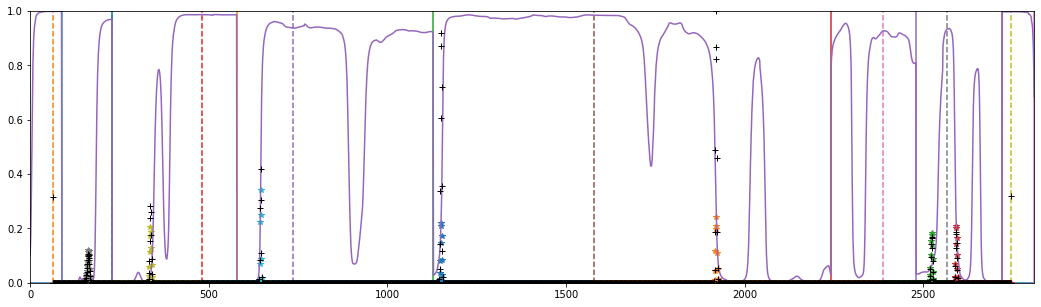

In [29]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18, 5))

ymax = 1

plt.plot([0, item[1][idx].item()], [0, 0])

for pivot in selected_frames_indices:
    plt.plot([pivot, pivot], [0, ymax], '--')
    
for pivot in boundary_frames_dict[cur_vidid + ".txt"]:
    plt.plot([pivot, pivot], [0, ymax])
    
all_prob = []
for i, segment in enumerate(prob_each_segment):
    segment = segment.cpu().numpy()
    print(f"Min prob {i} = {np.min(segment).item()}")
    xs = np.arange(selected_frames_indices[i], 
                   selected_frames_indices[i+1])
    plt.plot(xs, segment, '*')

    
plt_arr = []
for i in range(item[1][idx].item()):
    plt_arr.append(cur_vid_feat[i,item[2][idx][i]].item()) 
plt.plot(np.arange(item[1][idx].item()), plt_arr)


loss_prob = torch.softmax(cur_vid_feat.unsqueeze(0), dim=2)
es_loss, loss_arr = get_estimated_loss(loss_prob, torch.tensor([item_1[idx]]), [item[4][idx]])
loss_arr = -loss_arr[0].detach().cpu().numpy()
plt.plot(np.arange(selected_frames_indices[0] - 1, selected_frames_indices[-1] + 1), loss_arr/np.max(loss_arr), 'k+')

plt.ylim([0, ymax])
plt.xlim([0, item[1][idx].item()])

In [40]:
loss_prob = torch.softmax(cur_vid_feat.unsqueeze(0), dim=2)
print(loss_prob.shape)
es_loss, loss_arr = get_estimated_loss(loss_prob, torch.tensor([item_1[idx]]), [item[4][idx]], item_2[idx].unsqueeze(0))

torch.Size([1, 1895, 48])


In [43]:
loss_arr[0].shape

torch.Size([1387])

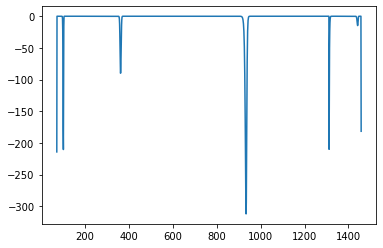

In [45]:
selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
plt.plot(np.arange(selected_frames[0] - 1, selected_frames[-1] + 1), loss_arr[0].detach().cpu().numpy())

In [44]:
es_loss

tensor(3.3987, device='cuda:0', dtype=torch.float64)

In [35]:
video_id_boundary_frames[cur_vidid], loaded_vidid_selected_frames[cur_vidid + ".txt"], item_1[idx]

([75, 345, 1305, 1415, 1440, 1519],
 [73, 282, 455, 1312, 1434, 1458],
 tensor(1520, device='cuda:0', dtype=torch.int32))

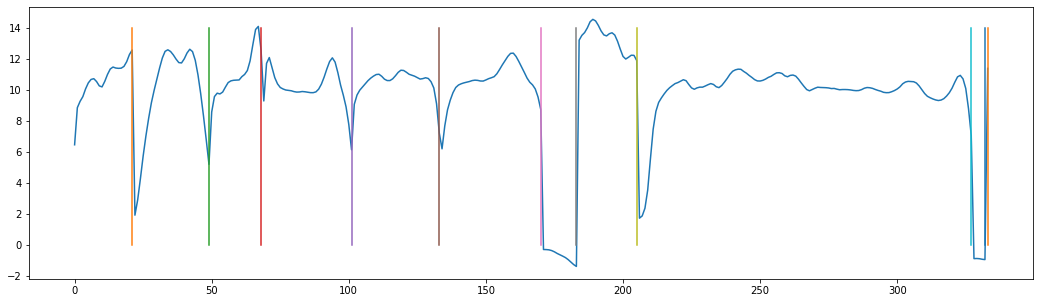

In [41]:
plt_arr = []
for i in range(item[1][idx].item()):
    plt_arr.append(cur_vid_feat[i,item[2][idx][i]].item()) 

fig = plt.figure(figsize=(18, 5))
plt.plot(np.arange(item[1][idx].item()), plt_arr)

for pivot in video_id_boundary_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, 14])

torch.Size([334, 334])

In [37]:
cur_features_shortened = cur_vid_feat[:item[1][idx]]
cur_features_shortened[:, item[2][idx][:item[1][idx]]].shape
for

torch.Size([334, 334])

In [26]:
item[2][idx][video_id_boundary_frames[cur_vidid][1]-6:video_id_boundary_frames[cur_vidid][1]+9]

tensor([47, 47, 47, 47, 47, 47, 47,  4,  4,  4,  4,  4,  4,  4,  4])

In [25]:
video_id_boundary_frames[cur_vidid][0]-6,video_id_boundary_frames[cur_vidid][0]+9

6

In [27]:
cur_vid_feat[video_id_boundary_frames[cur_vidid][1]-7:video_id_boundary_frames[cur_vidid][1]+9][:,[47,4]]

tensor([[ 1.0794, 13.3350],
        [ 1.0831, 13.5102],
        [ 1.1767, 13.7662],
        [ 1.3750, 14.0177],
        [ 1.7298, 14.1727],
        [ 2.1706, 14.0367],
        [ 2.7338, 13.4563],
        [ 4.5600, 12.1745],
        [ 7.8450, 10.3246],
        [11.0151,  8.3563],
        [13.4775,  6.6546],
        [14.1836,  5.2898],
        [11.2142,  4.2791],
        [ 5.9829,  3.5694],
        [ 2.3440,  2.9389],
        [ 0.7406,  2.3515]], device='cuda:0')

In [19]:
def add_frames_and_get_classification_value(model_output, count_list, video_ids_list, labels_all, p_criterion):
    new_selected_frames = {}
#     new_selected_frames_probs_values = {}
#     new_selected_frames_labels = {}
    
    labels_arr = []
    probs_arr = []
    
    for i, video_id in enumerate(video_ids_list):
        current_boundary_frames = boundaries_dict[video_id]
        current_video_logits = model_output[i].T
        current_video_count = count_list[i]
        current_selected_frames = loaded_vidid_selected_frames[video_id]
        labels = labels_all[i]
        cur_seg_start = 0
        for seg_num, ele in enumerate(current_boundary_frames):
            cur_seg_end = ele + 1
            total_seg_len = cur_seg_end - cur_seg_start
            per_frames_far_from_boundary = int(0.3 * total_seg_len)
            new_frames_start = cur_seg_start + per_frames_far_from_boundary
            new_frames_end = cur_seg_end - per_frames_far_from_boundary
            
            frames_added = list(range(new_frames_start, new_frames_end))
            frames_added.append(current_selected_frames[seg_num])
            frames_added = list(set(frames_added))
            frames_added.sort()
            new_selected_frames[video_id] = frames_added

            
            labels_seg = torch.stack([labels[current_selected_frames[seg_num]]] * len(frames_added))
            frames_added = torch.tensor(np.array(frames_added), dtype=torch.long, device=current_video_logits.device)
            prob_seg = current_video_logits[frames_added, :]
            
            labels_arr.append(labels_seg)
            probs_arr.append(prob_seg)
            
            cur_seg_start = cur_seg_end
            
    labels_arr = torch.cat(labels_arr)
    probs_arr = torch.cat(probs_arr)
    loss = p_criterion(probs_arr, labels_arr)
    return loss

In [22]:
def find_mask_for_this_class(video_len, weakly_labels_video, old_index_label_pair_list, 
                             cur_ele_searched, cur_index_searched):
    searched_label_index = np.where(cur_ele_searched == np.array(weakly_labels_video))[0]
    if len(searched_label_index) <= 1:
        mask = torch.ones(video_len)
        return mask
    else:
        start = 0
        for i, index in enumerate(searched_label_index[:-1]):
            cur_index_frame_selected = old_index_label_pair_list[index][0]
            next_index = searched_label_index[i + 1]
            next_index_frame_selected = old_index_label_pair_list[next_index][0]
            
            mid_select = (cur_index_frame_selected + next_index_frame_selected) // 2
            
            if index == cur_index_searched:
                mask = torch.zeros(video_len)
                mask[start: mid_select + 1] = 1
                return mask
            
            start = mid_select
        if searched_label_index[-1] == cur_index_searched:
            mask = torch.zeros(video_len)
            mask[start: video_len] = 1
            return mask
        else:
            import pdb
            pdb.set_trace()
            return "Error 1"
    return "Error"

In [23]:
# [2, 2, 2, 2, 3, 3, 4, 4, 3, 3, 2, 2, 2, 2]
find_mask_for_this_class(12, [2, 3, 4, 3,  2], [3, 5, 7, 8, 10], 4, 2)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])